Simple example of EnKF assimilation on the Lorenz-96 system.

The system state is composed of $N$ variables $x_1, ..., x_N$ with periodic boundaries (i.e. $x_{N+1} = x_{1}, x_{0} = x_N, x_{-1} = x_{N-1}$).

For $i=1, ..., N$, its evolution is described by:

$\frac{dx_i}{dt} = (x_{i+1} - x_{i-2}) x_{i-1} - x_i + F$

We will use the most common choices $N=40$ and $F=8$.

In [ ]:
import os
import torch
from matplotlib import pyplot as plt
from time import time
from tensordict import TensorDict
from mdml_sim.lorenz96 import L96Simulator
os.chdir('..')
from da_tools.variational.hard_constraint_4dvar import hc4dvar_single_window
from da_tools.system.state import State
from da_tools.observation.operators import random_sparse_noisy_obs
from da_tools.util.initialization import naive_initialization
from da_tools.util.visualization import show_1dseqimg, plot_ensemble_analysis
# Import the EnKF class
from da_tools.ensemble.enkf import EnKF, enkf

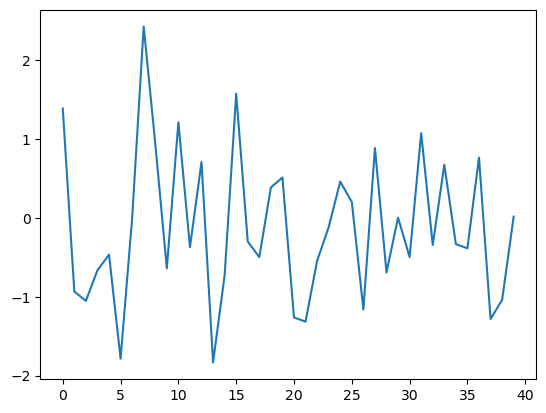

In [ ]:
# Define a target initial state
n_variables = 40 # N = 40
initial_state = State(torch.randn(1, 1, n_variables))  # (batch, time, n_variables)
plt.plot(initial_state.fields['x'].squeeze())

torch.Size([1000, 40])


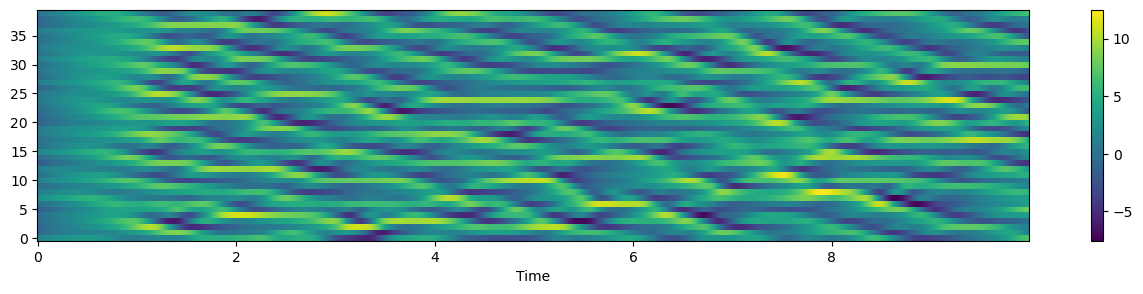

In [ ]:
# Generate a time series from the defined initial_condition using our L96 simulator
forward_operator = L96Simulator(forcing=8.0) # F = 8
ts_length = 1000
time_step = 0.01 # one time step = 0.01 second
forecast_steps = torch.arange(0, ts_length * time_step, time_step)
ts = forward_operator.integrate(time=forecast_steps, state=initial_state.fields['x'].reshape(1, -1)).squeeze()

print(ts.shape)
show_1dseqimg(ts.T, dt=time_step, x_label="Time")

One can see that, for roughly the first second of the forecast, the state is less structured than during the remaining of the time series. This is due to the fact that our sampled initial condition was not taken from the actual stationary distribution of the L96 system. In order to make up for this issue, we will "burn" the first 2 seconds of the time series and actually perform our assimilation on the remaining 8 seconds of data only.

In [ ]:
cutoff_time = 2
cutoff_index = int(cutoff_time / time_step)
true_ts = ts[cutoff_index:]
true_initial_state = true_ts[0]
forecast_steps = torch.arange(0, ts_length * time_step - cutoff_time, time_step)

true_ts = State(true_ts.reshape(1, -1, n_variables), time_axis=forecast_steps)

We now add some Gaussian noise and a binary mask on the true time series, in order to generate corresponding observations.

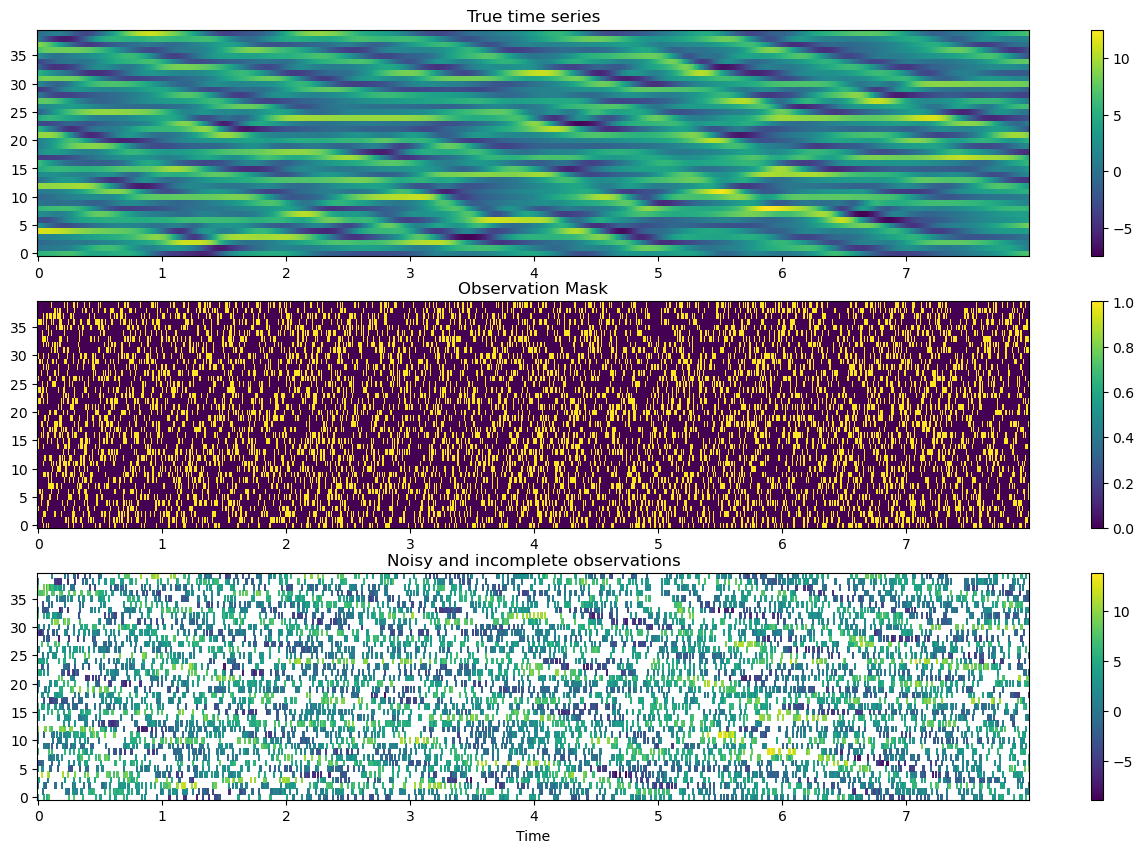

In [ ]:
noise_amplitude = 1.0  # observation noise s.d.
p_obs = 0.25 # 75% of the variables are masked

groundtruth, obs_op, observations = random_sparse_noisy_obs(true_ts, noise_amplitude, p_obs)

valid_obs = observations.state.fields['x'][0].T
valid_obs[torch.logical_not(observations.mask.fields['x'][0].T)] = torch.nan

fig, ax = plt.subplots(3, 1, figsize=(16,10))

show_1dseqimg(true_ts.fields['x'][0].T, dt=time_step, ax=ax[0], title="True time series")
show_1dseqimg(observations.mask.fields['x'][0].T, dt=time_step, ax=ax[1], title="Observation Mask")
show_1dseqimg(valid_obs, dt=time_step, ax=ax[2], title="Noisy and incomplete observations", x_label="Time")

Let us define the dynamical system of Lorenz96

In [ ]:
# we define a simple one-time-step function in order to fit the da-tools conventions
# In order to use the 4Dvar/EnKF function, you should always have a function like this taking the state, dt, dynamic_inputs and static_inputs

def next_step_function(x: State, dt: float, dynamic_inputs: State, static_inputs: State):
    "this time stepping function expects the input State x to have a single field called 'x'"
    B, T = x.fields.batch_size[:2]
    integrated = forward_operator.integrate(torch.arange(2) * dt, x.fields["x"])[:, -1, :] # integrate over a time step, take the current time
    integrated = integrated.unsqueeze(1)  # re-add time dimension
    new_fields = TensorDict(x=integrated, batch_size=(B, T))
    return State(new_fields, time_axis=x.time_axis + dt)  # return State object, advancing time

## First, we want to see the result without data assimilation

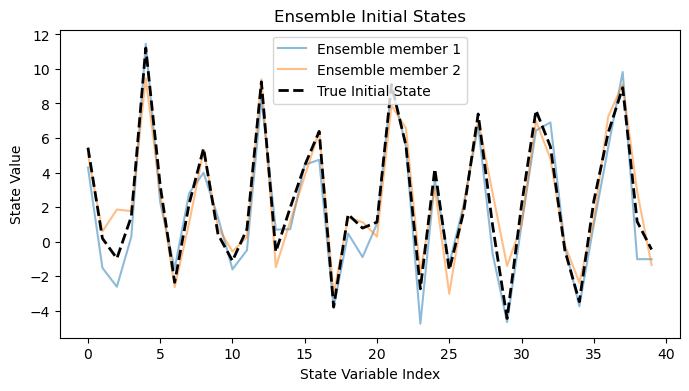

In [ ]:
n_members = 2
initial_ensemble_std = 1.0
# Initialize EnKF
enkf_obj = EnKF(
    n_members=n_members,
    n_variables=n_variables,
    initial_ensemble_std=initial_ensemble_std
)

# Create initial ensemble around a naive initialization
true_initial_state = true_ts[:, :1]
ensemble_initial_states = enkf_obj.initialize_ensemble(true_initial_state)
# Plot the ensemble initial states
plt.figure(figsize=(8, 4))
for i in range(n_members):
    plt.plot(ensemble_initial_states.fields["x"][i, 0, :], alpha=0.5, label=f'Ensemble member {i+1}' if i < 5 else "")
plt.plot(true_initial_state.fields["x"][0, 0, :], 'k--', linewidth=2, label='True Initial State')
plt.title('Ensemble Initial States')
plt.xlabel('State Variable Index')
plt.ylabel('State Value')
plt.legend()
plt.show()

In [ ]:
# Run Lorenz96 simulations for ensemble_initial_states (State object)
ensemble_trajectories = []
simulation_steps = 800  # Number of time steps to simulate
sim_time_axis = torch.arange(0, simulation_steps * time_step, time_step)

print(f"Running simulations for {simulation_steps} time steps...")
print(f"Ensemble initial states shape: {ensemble_initial_states.fields['x'].shape}")

# Extract individual ensemble members from the State object
for i in range(n_members):
    print(f"Simulating ensemble member {i+1}/{n_members}...")
    
    # Extract the i-th ensemble member: shape (n_variables,)
    member_initial_state = ensemble_initial_states.fields['x'][i, 0, :]  # [batch, time, variables]
    
    # Run the simulation for this ensemble member
    trajectory = forward_operator.integrate(
        time=sim_time_axis, 
        state=member_initial_state.unsqueeze(0)  # Add batch dimension for L96Simulator
    ).squeeze()  # Remove batch dimension: shape (time_steps, n_variables)
    
    ensemble_trajectories.append(trajectory)
    
    if (i + 1) % 10 == 0 or i == 0:  # Print progress every 10 members
        print(f"  Completed {i+1} ensemble members. Trajectory shape: {trajectory.shape}")

print(f"\nCompleted simulations for all {n_members} ensemble members!")

# Verify shapes
print(f"Number of ensemble trajectories: {len(ensemble_trajectories)}")
print(f"Each trajectory shape: {ensemble_trajectories[0].shape}")

# Stack all ensemble trajectories for easier analysis
ensemble_trajectories_tensor = torch.stack(ensemble_trajectories)  # Shape: (n_members, time_steps, n_variables)
print(f"Stacked ensemble trajectories shape: {ensemble_trajectories_tensor.shape}")

# Calculate ensemble statistics
ensemble_mean = ensemble_trajectories_tensor.mean(dim=0)  # Mean across ensemble members
ensemble_std = ensemble_trajectories_tensor.std(dim=0)    # Std across ensemble members

print(f"Ensemble mean shape: {ensemble_mean.shape}")
print(f"Ensemble std shape: {ensemble_std.shape}")

# Run true trajectory for comparison
print(f"\nRunning true trajectory for comparison...")
true_sim = forward_operator.integrate(
    time=sim_time_axis, 
    state=true_initial_state.fields['x'][0],
).squeeze()

print(f"True simulation shape: {true_sim.shape}")

# Calculate RMSE for each ensemble member vs true trajectory
rmse_ensemble = []
for i in range(n_members):
    rmse = torch.sqrt(((ensemble_trajectories[i] - true_sim) ** 2).mean(dim=1))  # RMSE over time
    rmse_ensemble.append(rmse)

# Calculate ensemble mean RMSE
ensemble_mean_rmse = torch.sqrt(((ensemble_mean - true_sim) ** 2).mean(dim=1))

# Print final statistics
print(f"\nFinal RMSE values (at t={sim_time_axis[-1]:.2f}s):")
print(f"Ensemble mean RMSE: {ensemble_mean_rmse[-1]:.4f}")
print(f"Individual member RMSEs:")
for i in range(min(5, n_members)):  # Print first 5 members
    print(f"  Member {i+1}: {rmse_ensemble[i][-1]:.4f}")
if n_members > 5:
    print(f"  ... and {n_members-5} more members")

Running simulations for 800 time steps...
Ensemble initial states shape: torch.Size([2, 1, 40])
Simulating ensemble member 1/2...
  Completed 1 ensemble members. Trajectory shape: torch.Size([800, 40])
Simulating ensemble member 2/2...

Completed simulations for all 2 ensemble members!
Number of ensemble trajectories: 2
Each trajectory shape: torch.Size([800, 40])
Stacked ensemble trajectories shape: torch.Size([2, 800, 40])
Ensemble mean shape: torch.Size([800, 40])
Ensemble std shape: torch.Size([800, 40])

Running true trajectory for comparison...
True simulation shape: torch.Size([800, 40])

Final RMSE values (at t=7.99s):
Ensemble mean RMSE: 4.4935
Individual member RMSEs:
  Member 1: 5.1274
  Member 2: 5.3159


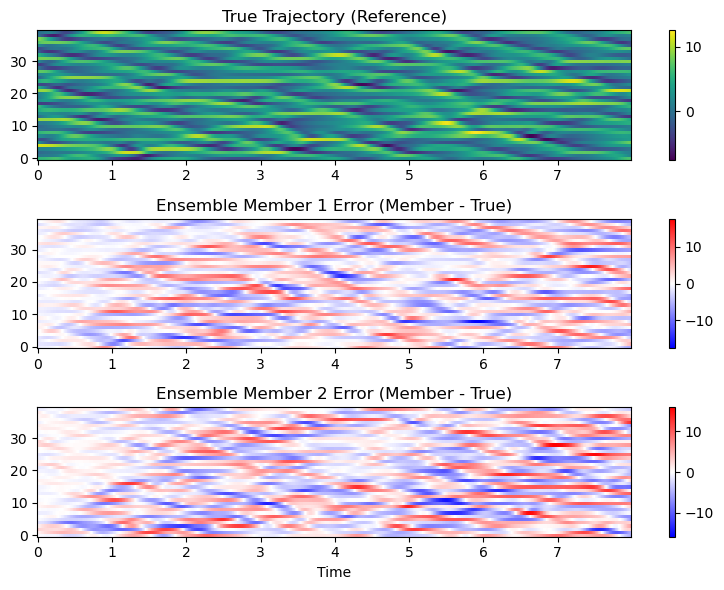

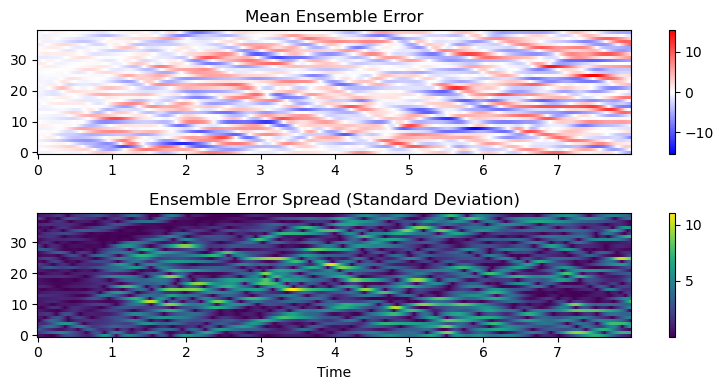

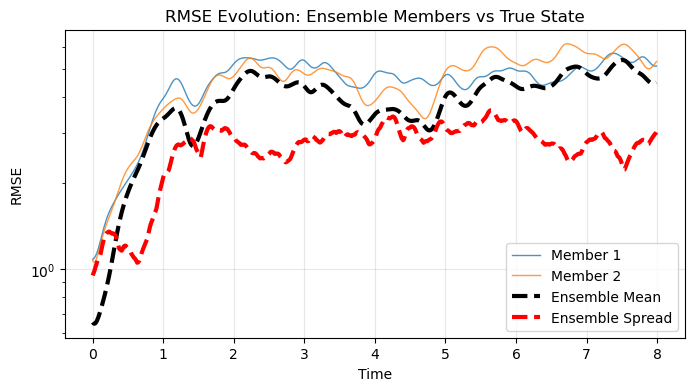


ENSEMBLE ANALYSIS SUMMARY

Final RMSE values (at t=7.99s):
Ensemble mean RMSE: 4.4935
Individual member RMSEs:
  Member 1: 5.1274
  Member 2: 5.3159

Final ensemble spread: 3.0110
Final ensemble mean RMSE: 4.4935
Spread/RMSE ratio: 0.67
  → Ensemble is under-dispersed (too confident)

RMSE at different time points:
Time       Member 1     Member 2     Ens. Mean    Spread      
-----------------------------------------------------------------
0.50       2.0530       2.2566       1.8618       1.1892      
1.00       3.9590       3.6377       3.3655       2.0994      
1.50       3.7879       3.6451       2.8820       2.5377      
1.99       5.1917       4.7097       4.2368       2.8936      


In [ ]:
# Usage example:
results = plot_ensemble_analysis(
    ensemble_trajectories=ensemble_trajectories,
    true_sim=true_sim,
    sim_time_axis=sim_time_axis,
    time_step=time_step,
    n_members=n_members,
    max_members_plot=10
)

Create an EnKF object with the number of ensembles specified. Let us examine without data assimilation, 2 initializations slightly differently due to noise will be gradually disturbent over time during the simulation. That behaviour reflects the nature of chaotic system.

## Run EnKF data assimilation with 200 members and initialization is generated by naive_intialization

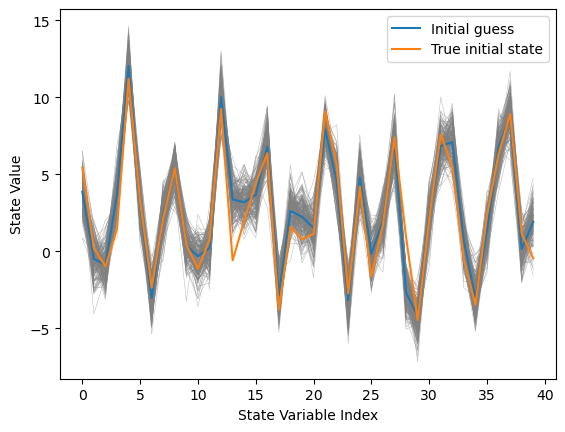

In [ ]:
initialization = naive_initialization(observations)  # state estimate for all time points
initialization = initialization[:,:1]  # first time point only
number_of_ensembles = 200
initial_ensemble_std = 1.0
enkf_obj = EnKF(n_members=number_of_ensembles, n_variables=initialization.fields["x"].shape[-1], initial_ensemble_std=initial_ensemble_std)
enkf_obj.initialize_ensemble(initialization)
# plot 200 ensemble members
for i in range(number_of_ensembles):
    plt.plot(enkf_obj.ensemble.fields['x'][i, 0], alpha=0.5, c='gray', linewidth=0.4)
plt.plot(initialization.fields['x'].squeeze(), label='Initial guess')
plt.plot(true_ts.fields['x'][0, 0], label='True initial state')
plt.xlabel('State Variable Index')
plt.ylabel('State Value')
plt.legend()

In [ ]:
# Run data assimilation
ensemble_states = enkf(
        m_dyn=next_step_function,
        observations=observations,
        obs_op=obs_op,
        x_init=initialization,
        n_members=number_of_ensembles,
        initial_ensemble_std=initial_ensemble_std,
    )

print(f"EnKF assimilation completed!")

EnKF assimilation completed!


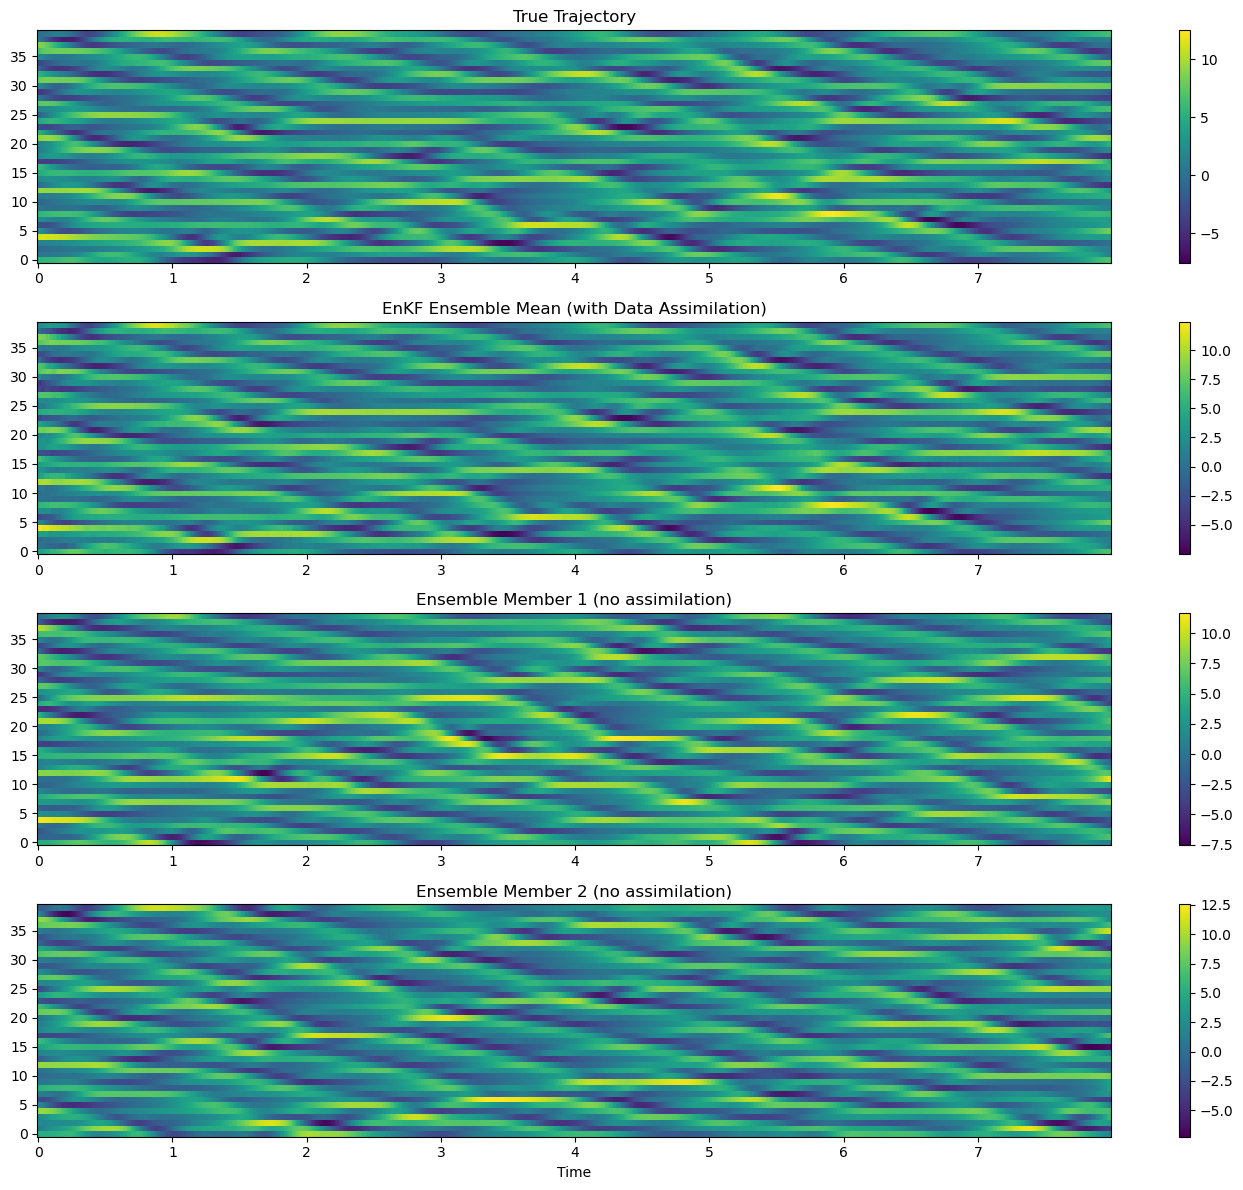

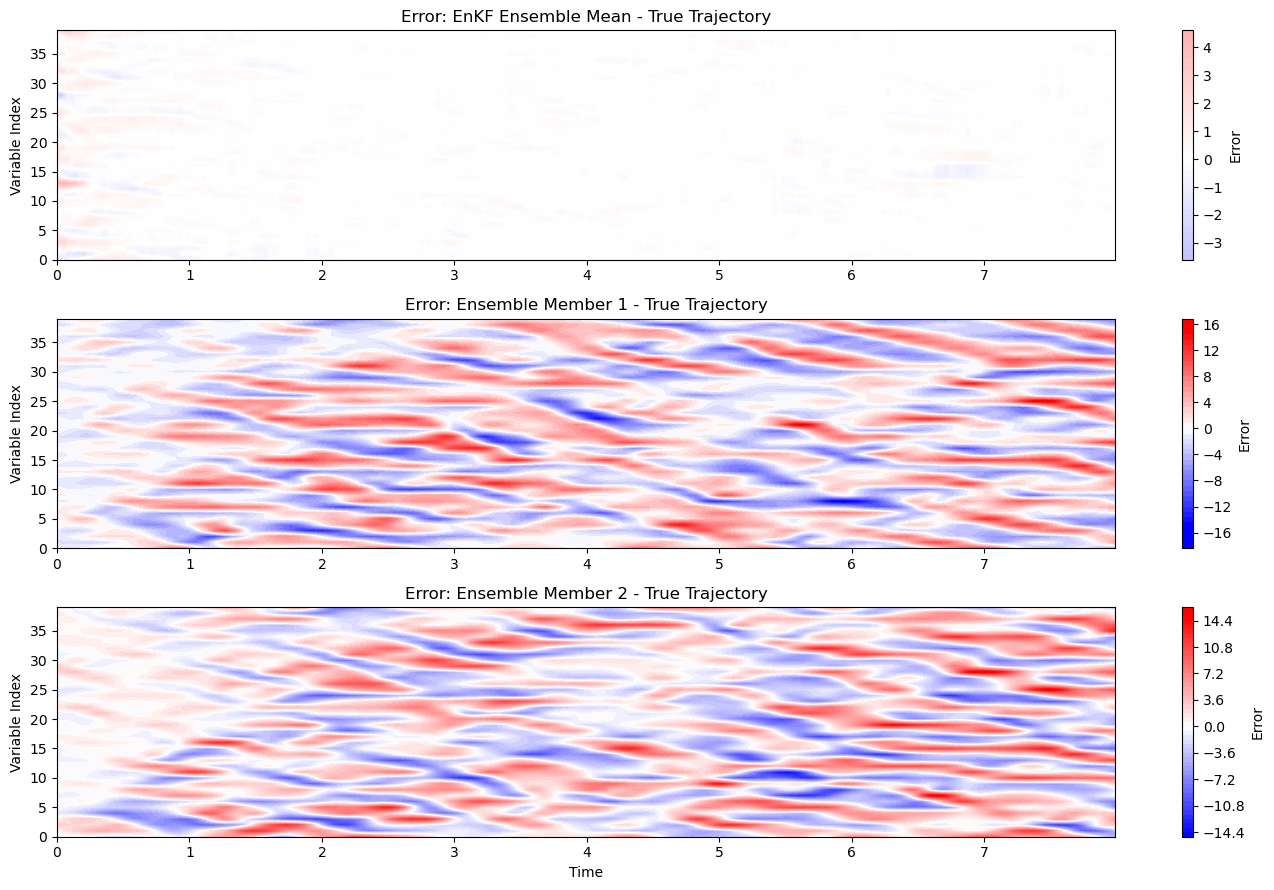


Trajectory Comparison Summary:
EnKF mean trajectory shape: torch.Size([40, 800])
True trajectory subset shape: torch.Size([40, 800])
Time steps compared: 800

Final RMSE at t=7.99s:
EnKF vs True: 0.0902
Ensemble Member 1 vs True: 5.2824
Ensemble Member 2 vs True: 5.4635

EnKF Improvement:
vs Member 1: 98.3%
vs Member 2: 98.3%

Debug Information:
Ensemble state shape: torch.Size([200, 800, 40])
EnKF time axis length: 800
Observations time axis length: 800


In [ ]:
# Plot true trajectory, EnKF results, and ensemble members over time
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
n_assimilation_steps = len(observations.state.time_axis)

# Time axis for plotting
assimilation_time_axis = torch.arange(0, n_assimilation_steps * time_step, time_step)
true_trajectory_subset = true_ts.fields['x'][0, :n_assimilation_steps, :].T
ensemble_subset = torch.stack([traj[:n_assimilation_steps, :] for traj in ensemble_trajectories])
ensemble_subset = ensemble_subset[:2]  # Limit to first 2 members for clarity

# 1. True trajectory
show_1dseqimg(true_trajectory_subset, dt=time_step, ax=axes[0], 
              title="True Trajectory", x_label="")

# 2. EnKF ensemble mean (using returned ensemble_states)
# Extract ensemble mean from the returned State object
enkf_full_history = ensemble_states.fields['x']  # Shape: (n_members, n_time_steps, n_variables)
enkf_mean_trajectory = enkf_full_history.mean(dim=0).T  # Shape: (n_variables, n_time_steps)

# Ensure we only use the time steps that match the observations
min_time_steps_enkf = min(enkf_mean_trajectory.shape[1], n_assimilation_steps)
enkf_mean_trajectory = enkf_mean_trajectory[:, :min_time_steps_enkf]

show_1dseqimg(enkf_mean_trajectory, dt=time_step, ax=axes[1], 
              title="EnKF Ensemble Mean (with Data Assimilation)", x_label="")

# 3. & 4. Ensemble members before data assimilation (free forecast)
for i, member_traj in enumerate(ensemble_subset):
    show_1dseqimg(member_traj.T, dt=time_step, ax=axes[2+i], 
                  title=f"Ensemble Member {i+1} (no assimilation)", 
                  x_label="Time" if i == len(ensemble_subset)-1 else "")

plt.tight_layout()
plt.show()

# Plot contour error plots for (1) EnKF mean, (2) Ensemble member 1, (3) Ensemble member 2 vs true trajectory
fig, axes = plt.subplots(3, 1, figsize=(14, 9))
vmax = 15.0  # Set a common color scale limit for better comparison
vmin = -vmax

# 1. Error: EnKF ensemble mean - true trajectory
min_time_steps = min(enkf_mean_trajectory.shape[1], true_trajectory_subset.shape[1])
enkf_error = enkf_mean_trajectory[:, :min_time_steps] - true_trajectory_subset[:, :min_time_steps]

im1 = axes[0].contourf(
    assimilation_time_axis[:min_time_steps].numpy(),
    range(n_variables),
    enkf_error,
    levels=50,
    cmap='bwr',
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title("Error: EnKF Ensemble Mean - True Trajectory")
axes[0].set_ylabel("Variable Index")
plt.colorbar(im1, ax=axes[0], orientation='vertical', label='Error')

# 2. Error: Ensemble member 1 - true trajectory
ens1_error = ensemble_subset[0].T[:, :min_time_steps] - true_trajectory_subset[:, :min_time_steps]
im2 = axes[1].contourf(
    assimilation_time_axis[:min_time_steps].numpy(),
    range(n_variables),
    ens1_error,
    levels=50,
    cmap='bwr',
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title("Error: Ensemble Member 1 - True Trajectory")
axes[1].set_ylabel("Variable Index")
plt.colorbar(im2, ax=axes[1], orientation='vertical', label='Error')

# 3. Error: Ensemble member 2 - true trajectory
ens2_error = ensemble_subset[1].T[:, :min_time_steps] - true_trajectory_subset[:, :min_time_steps]
im3 = axes[2].contourf(
    assimilation_time_axis[:min_time_steps].numpy(),
    range(n_variables),
    ens2_error,
    levels=50,
    cmap='bwr',
    vmin=vmin,
    vmax=vmax
)
axes[2].set_title("Error: Ensemble Member 2 - True Trajectory")
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Variable Index")
plt.colorbar(im3, ax=axes[2], orientation='vertical', label='Error')

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"\nTrajectory Comparison Summary:")
print(f"EnKF mean trajectory shape: {enkf_mean_trajectory.shape}")
print(f"True trajectory subset shape: {true_trajectory_subset.shape}")
print(f"Time steps compared: {min_time_steps}")

# Calculate final errors
final_enkf_error = torch.sqrt((enkf_error[:, -1] ** 2).mean())
final_ens1_error = torch.sqrt((ens1_error[:, -1] ** 2).mean())
final_ens2_error = torch.sqrt((ens2_error[:, -1] ** 2).mean())

print(f"\nFinal RMSE at t={assimilation_time_axis[min_time_steps-1]:.2f}s:")
print(f"EnKF vs True: {final_enkf_error:.4f}")
print(f"Ensemble Member 1 vs True: {final_ens1_error:.4f}")
print(f"Ensemble Member 2 vs True: {final_ens2_error:.4f}")

# Calculate improvement
improvement_1 = ((final_ens1_error - final_enkf_error) / final_ens1_error) * 100
improvement_2 = ((final_ens2_error - final_enkf_error) / final_ens2_error) * 100

print(f"\nEnKF Improvement:")
print(f"vs Member 1: {improvement_1:.1f}%")
print(f"vs Member 2: {improvement_2:.1f}%")

# Optional: Print some debug information
print(f"\nDebug Information:")
print(f"Ensemble state shape: {ensemble_states.fields['x'].shape}")
print(f"EnKF time axis length: {len(ensemble_states.time_axis) if ensemble_states.time_axis is not None else 'None'}")
print(f"Observations time axis length: {len(observations.state.time_axis)}")